ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **13Apr21**

# 11. Peclet Bulk-Coupled 1D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Source Coupling](#sourcecoupling)
 + [Weak Form](#dbcweak)
<br><br>
1. [Problem Solution](#solution)
 + [Code a Source Term Kernel](#sourcekernel)
 + [Compile and Link Application](#compile)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [High Peclet Number](#highpe)
 + [Quadratic Lagrange FEM Results](#highperesults1)
    - [Compute Error](#highperesults1error)
 + [Quadratic Lagrange FEM Results](#highperesults2)
    - [Compute Error](#highperesults2error)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

+ Introduce bulk-coupling in the context of a Peclet problem studied in the notebook series 09; all past notebooks must be thoroughly reviewed.
+ Present the Galerkin weak form of the Peclet 1D problem with two unknown variables as described below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
+ <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span> 
+ The reader is supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  u1_legend='no u1 legend',
                  u2_legend='no u2 legend',
                  u1_flux_legend='no u1 flux legend',
                  u2_flux_legend='no u2 flux legend'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(15, 6))

    ax1.plot(df['x'], df['u'],'r*-',label=u1_legend)
    
    if 'u2' in df.columns:
        ax1.plot(df['x'], df['u2'],'r*--',label=u2_legend)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=u1_flux_legend)
        
        if 'diffFluxU2_x' in df.columns:
            ax2.plot(df['x'], df['diffFluxU2_x'],'*--', color='yellow', label=u2_flux_legend)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

There exists two kinds of coupling of unknown variables (or fields), one kind is when the fields share the same domain $\Omega$ and are coupled tightly over the entire $\Omega$. This is the kind that will be studied here. The other kind is when the fields do not share the same domain $\Omega$ and the coupling takes place on a portion of the boundary of $\Omega$ shared by the fields. This latter case will be described in a future notebook.

The following sections describe an extension of the Peclet problem described in previous notebooks for the case when two fields are coupled through a source term.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Peclet model problem. Find $u_1:[a,b]\subset\Reals\rightarrow\Reals$ and $u_2:[a,b]\subset\Reals\rightarrow\Reals$ for $D_1 > 0$ and $D_2 > 0$ such that:

\begin{align*}
  v\, u_1' &= -\bigl(-D_1\, u_1'\bigr)'(x) + S(u_1, u_2) \quad \forall \quad x\in [a,b], \\
 u_1(a) &= A_1, \\
 u_1(b) &= B_1.
\end{align*}

and

\begin{align*}
  v\, u_2' &= -\bigl(-D_2\, u_2'\bigr)'(x) - S(u_1, u_2) \quad \forall \quad x\in [a,b], \\
 u_2(a) &= A_2, \\
 u_2(b) &= B_2.
\end{align*}

The *diffusion flux* associated to the quantity $u_i, \, \ i=1,2$ is denoted $q_i := -D_i\,u_i'$, and it is often of interest as a derived quantity. Here a point-wise *convective sink (or sweep)* is given by $v\,u_i'$. There exists two Peclet numbers: 

  + Peclet number: $\frac{v\,L}{D_i}$. 

whose effects has been described in earlier notebooks.

Likewise in the single-field Peclet 1-D problem (Notebook 09), the values of the dependent variables are given on the two end points of the domain (*essential* boundary conditions or  *Dirichlet boundary conditions*).

### [Source Coupling](#toc)<a id="sourcecoupling"></a>

Consider the following source coupling:

\begin{align*}
 S(u_1, u_2) = S_1 - h_1\,\bigl(u_1-u_1^*\bigr) - \Bigl( S_2 - h_2\, \bigl(u_2 - u_2^*\bigr) \Bigr)
\end{align*}

where $S_i$ is a fixed source (sink) for each field, $h_i$ is a transfer coefficient, and $u_i^*$ is a saturation value.

### [Weak Form of the Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin weak formulation is as follows. Find $u_1 \in H^1\!\bigl([a,b]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b v\, u_1'(x)\, w(x)\,dx + \int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

The new form of the source term is the key term to be computed here. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integral, that is, the kernel. Therefore the kernel needed is an expansion of what has been covered so far in the course:

 1. $\pm S(u_1, u_2)\,w(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

## [Problem Solution](#toc)<a id="solution"></a>

We will leverage the Peclet 1D development (Notebook 09) to modify the source term where the coupling takes place.

### [Code a Source Term Kernel](#toc)<a id="sourcekernel"></a>

1. Starting from the Peclet 1D development, the source kernel file `SourceTerm.h` can be modified as follows:
   ```c++
  /// The variables associated to the source
  const Real _sourceS;
  const Real _transferCoeff;
  const Real _saturation;

  const VariableValue & _uCoupled;
  const Real _sourceSCoupled;
  const Real _transferCoeffCoupled;
  const Real _saturationCoupled;
   ```
1. Likewise the `SourceTerm.C` class implementation can be also changed to:

Residual:
  ```c++
Real
SourceTerm::computeQpResidual()
{
 return  ( (_sourceS - _transferCoeff * (_u[_qp] - _saturation))              \
          -(_sourceSCoupled -_transferCoeffCoupled * (_uCoupled[_qp] - _saturationCoupled)) )  \
         * _test[_i][_qp];
}

  ```
Jacobian diagonal:
 ```c++
 Real
 SourceTerm::computeQpJacobian()
 {
  return (- _transferCoeff + _transferCoeffCoupled) * _phi[_j][_qp] * _test[_i][_qp];
 }
 ```


### [Compile and Link Application](#toc)<a id="compile"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

The newly revised source kernel can now be used for both fields:

```
  [source-term-1]
    type = SourceTerm
    variable = u1     # add to produced quantity
    sourceS = ${replace source_s_1}
    transferCoeff = ${replace source_transfer_coeff_1}
    saturation = ${replace source_saturation_1}
    coupledVariable = u2
    sourceSCoupled = ${replace source_s_2}
    transferCoeffCoupled = ${replace source_transfer_coeff_2}
    saturationCoupled = ${replace source_saturation_2}
  []
  [source-term-2]
    type = SourceTerm
    variable = u2     # add to produced quantity
    sourceS = ${replace source_s_2}
    transferCoeff = ${replace source_transfer_coeff_2}
    saturation = ${replace source_saturation_2}
    coupledVariable = u1
    sourceSCoupled = ${replace source_s_1}
    transferCoeffCoupled = ${replace source_transfer_coeff_1}
    saturationCoupled = ${replace source_saturation_1}
  []
```
On the working examples below a cleaner version with defaults is used to avoid writing entries with zero values.
Additional blocks in the input file can be used to create the weak form for both variables as described below.

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + $a = 0$ cm
> + $b = 25$ cm

> + Pe$_\text{ave} = 10$

| $u_1$ **Parameter** | **Value**  | $u_2$ **Parameter** | **Value** |
|:-------------------:|:----------:|:-------------------:|:---------:|
| $A_1$               | 3 g/cc     |  $A_2$              | 0 g/cc    |
| $B_1$               | 0 g/cc     |  $B_2$              | 0 g/cc    |
| $D_1$               | 0.1 cm^2/s |  $D_2$              | 0.1 cm^2/s  |
| $S_1$               | $1\times 10^{-3}$ g/cc-s |  $S_2$              | 0 g/cc-s  |
| $h_1$               | $5\times 10^{-3}$ cm/s | $h_2$  | 0 cm/s |
| $u_1^*$             | 1.5 g/cc   | $u_2^*$     | 0 g/cc |

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 20

**Comment: This data tests the case when there is only transfer from $u_1$ to $u_2$. Other cases will be presented in another notebook.**

In [2]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [3]:
'''Parameters and data'''

Pe_ave = 10 # mildly convective dominated

diff_coeff_1 = 0.1
source_s_1 = 1e-3
source_transfer_coeff_1 = 5e-3
source_saturation_1 = 1.0

diff_coeff_2 = diff_coeff_1

velocity = (Pe_ave * (diff_coeff_1+diff_coeff_2)/2/x_length, 0, 0)  # length scale is the x length

u_a = 3
u_b = 0

u2_a = 0
u2_b = 0

In [4]:
'''FEM Solution'''

n_felem = 20

order = 'first'

n_plot_pts = n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff_1, source_s=source_s_1,
                                source_transfer_coeff=source_transfer_coeff_1, 
                                source_saturation=source_saturation_1,
                                u2_left=u2_a, u2_right=u2_b, 
                                diff_coeff_2=diff_coeff_2,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [5]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 20Apr21 16:12:37

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
source_transfer_coeff = 5.00000e-03
source_saturation = 1.00000e+00
u_left = 3.00000e+00
u_right = 0.00000e+00
u2_left = 0.00000e+00
u2_right = 0.00000e+00
diff_coeff_2 = 1.00000e-01
velocity = '4.00000e-02 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 20
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
  [u2]
    order = first
    family = lagrange
    initial_condition = ${fparse (u2_right+u2_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = CONSTANT
    family = MONOMIAL_VEC
  []
  [diffFluxU2]
    order = CONSTANT
    fa

In [6]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Tue Apr 20 16:12:38 2021
Executable Timestamp:    Mon Apr 19 21:44:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 21
    Local:                 21
  Elems:                   
    Total:                 20
    Local:                 20
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                42
  Num Local DOFs:          42
  Variables:               { "u" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                80
  Num Local DOFs:          80


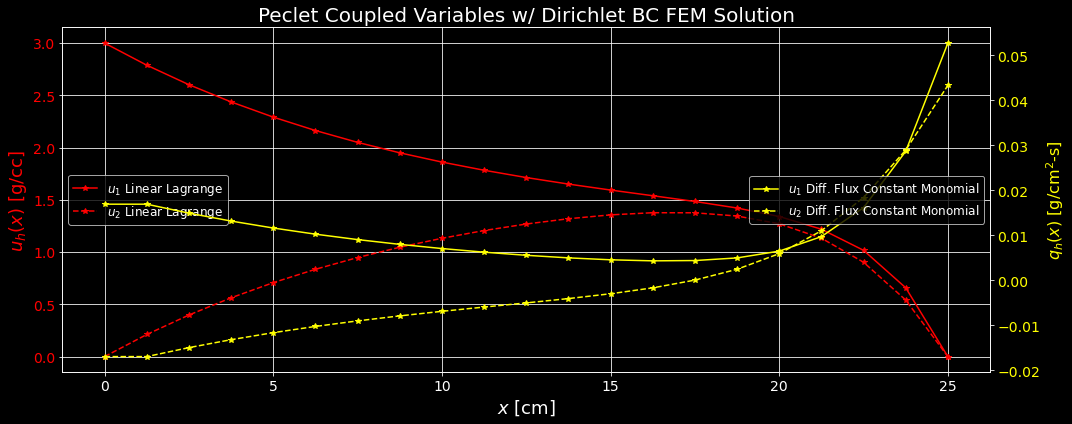

In [7]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

**Comments:**

1. The *concentration* of $u_1$ decreases as $u_2$ increases since there is only transfer from 1 to 2.

### [FEM Error](#toc)<a id="linearerror"></a>

In [8]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

**Comments:**

1. TBA
1. TBA

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with the same parameter values as above.

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 20

In [9]:
'''FEM Solution'''

n_felem = 20

order = 'second'

n_plot_pts = 2*n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff_1, source_s=source_s_1,
                                source_transfer_coeff=source_transfer_coeff_1, 
                                source_saturation=source_saturation_1,
                                u2_left=u2_a, u2_right=u2_b, 
                                diff_coeff_2=diff_coeff_2,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [10]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 20Apr21 16:12:39

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
source_transfer_coeff = 5.00000e-03
source_saturation = 1.00000e+00
u_left = 3.00000e+00
u_right = 0.00000e+00
u2_left = 0.00000e+00
u2_right = 0.00000e+00
diff_coeff_2 = 1.00000e-01
velocity = '4.00000e-02 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 20
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
  [u2]
    order = second
    family = lagrange
    initial_condition = ${fparse (u2_right+u2_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU2]
    or

In [11]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Tue Apr 20 16:12:39 2021
Executable Timestamp:    Mon Apr 19 21:44:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 41
    Local:                 41
  Elems:                   
    Total:                 20
    Local:                 20
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                82
  Num Local DOFs:          82
  Variables:               { "u" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                160
  Num Local DOFs:          1

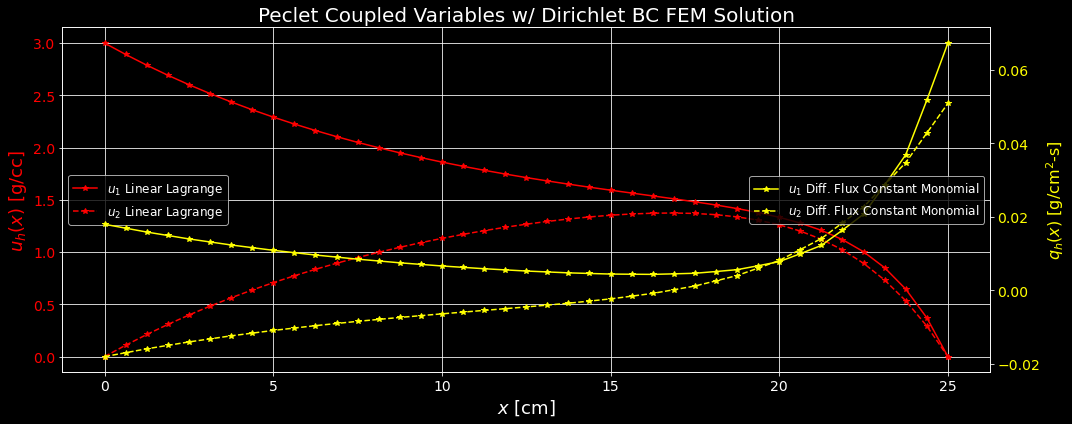

In [12]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

### [FEM Error](#toc)<a id="quaderror"></a>


In [13]:
'''Error Compared to Exact Dimensionless Solution'''

'''comming...'''

'comming...'

**Comments:**

1. TBA

## [High Peclet Number](#toc)<a id="highpe"></a>

Highly convective problems may lead to numerical difficulties. Below, enough finite elements are chosen so to avoid oscillations. 

### [Quadratic Lagrange FEM](#toc)<a id="highperesults1"></a>

Solve problem with the same parameter values above.

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

In [14]:
'''Parameters and data'''

Pe_ave = 50 # convective dominated

velocity = (Pe_ave * (diff_coeff_1+diff_coeff_2)/2/x_length, 0, 0)  # length scale is the x length

In [15]:
'''FEM Solution'''

n_felem = 10

order = 'second'

n_plot_pts = 2*n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff_1, source_s=source_s_1,
                                source_transfer_coeff=source_transfer_coeff_1, 
                                source_saturation=source_saturation_1,
                                u2_left=u2_a, u2_right=u2_b, 
                                diff_coeff_2=diff_coeff_2,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [16]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 20Apr21 16:12:40

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
source_transfer_coeff = 5.00000e-03
source_saturation = 1.00000e+00
u_left = 3.00000e+00
u_right = 0.00000e+00
u2_left = 0.00000e+00
u2_right = 0.00000e+00
diff_coeff_2 = 1.00000e-01
velocity = '2.00000e-01 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
  [u2]
    order = second
    family = lagrange
    initial_condition = ${fparse (u2_right+u2_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU2]
    or

In [17]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Tue Apr 20 16:12:40 2021
Executable Timestamp:    Mon Apr 19 21:44:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 21
    Local:                 21
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                42
  Num Local DOFs:          42
  Variables:               { "u" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                80
  Num Local DOFs:          80

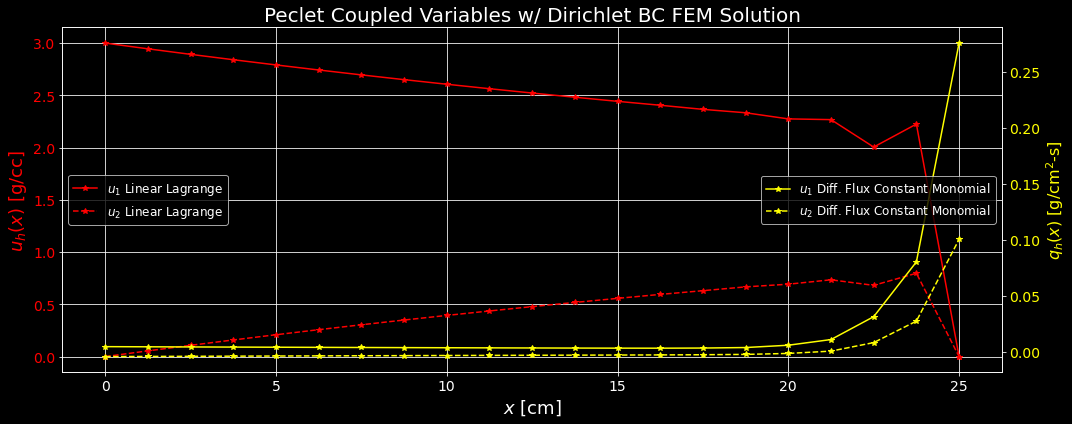

In [18]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

**Comments:**

As convection dominates, the boundary layer sharpens and numerical instability appears in the form of oscillations. Either an increase of number of finite element basis functions or mesh adaptivity could resolve the boundary layer as demonstrated below.

#### [Compute Error](#toc)<a id="highperesults1error"></a>


In [19]:
'''Flux Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

### [Quadratic Lagrange FEM](#toc)<a id="highperesults2"></a>

Solve problem with the same parameter values above.

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 20

In [20]:
'''FEM Solution'''

n_felem = 10

x_bias = .5  # mesh adaptivity

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts *= 2

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff_1, source_s=source_s_1,
                                source_transfer_coeff=source_transfer_coeff_1, 
                                source_saturation=source_saturation_1,
                                u2_left=u2_a, u2_right=u2_b, 
                                diff_coeff_2=diff_coeff_2,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                x_bias=x_bias,
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [21]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 20Apr21 16:12:40

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
source_transfer_coeff = 5.00000e-03
source_saturation = 1.00000e+00
u_left = 3.00000e+00
u_right = 0.00000e+00
u2_left = 0.00000e+00
u2_right = 0.00000e+00
diff_coeff_2 = 1.00000e-01
velocity = '2.00000e-01 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
    elem_type = edge3
    bias_x = 5.000e-01
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
  [u2]
    order = second
    family = lagrange
    initial_condition = ${fparse (u2_right+u2_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  [

In [22]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Tue Apr 20 16:12:41 2021
Executable Timestamp:    Mon Apr 19 21:44:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 21
    Local:                 21
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                42
  Num Local DOFs:          42
  Variables:               { "u" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                80
  Num Local DOFs:          80

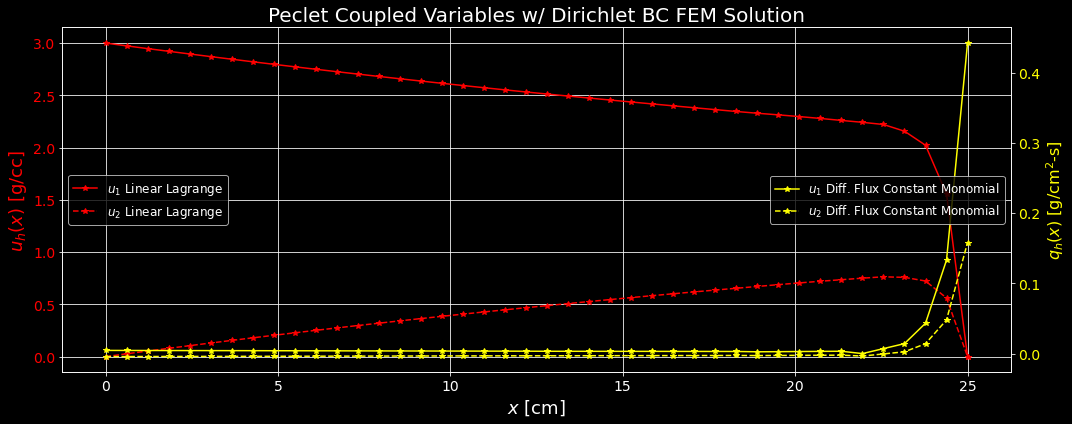

In [23]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

**Comments:**

1. The mesh adaptivity with refinement on the right side of the domain captures the exit boundary layer. An increase of the number of finite element would also correct the oscillation issue but this strategy is often undesirable.

#### [Compute Error](#toc)<a id="highperesults2error"></a>

In [24]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming'''

'coming'

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [25]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 